# Data visualization

## Read train / dev data

In [1]:
import os
import re
import pandas as pd
import numpy as np
import random
import sklearn
import codecs
import collections
from tqdm import tqdm
import torch
from textblob import TextBlob

from sklearn.metrics import classification_report, accuracy_score

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
TRAIN_DIR = "./data/training/"
TRAIN_SUFFIX = "-train.txt"

DEV_DIR = "./data/development/"
DEV_SUFFIX = "-dev.txt"

TEST_DIR = "./data/test-gold/"
TEST_SUFFIX = "-test-gold.txt"

YEAR_PREFIX = "2018-"
FILE_PREFIX = "EI-oc-En-"

EMOTIONS = ["anger", "fear", "joy", "sadness"] 
LABEL_EMOTIONS = {i: emo for i, emo in enumerate(EMOTIONS)}
EMOTIONS_LABEL = {emo: i for i, emo in enumerate(EMOTIONS)}

In [3]:
TRAIN_FILES = []
DEV_FILES = []
TEST_FILES = []

for emo in EMOTIONS: 
    TRAIN_FILES += [TRAIN_DIR + FILE_PREFIX + emo + TRAIN_SUFFIX]
    DEV_FILES += [DEV_DIR + YEAR_PREFIX + FILE_PREFIX + emo + DEV_SUFFIX]
    TEST_FILES += [TEST_DIR + YEAR_PREFIX + FILE_PREFIX + emo + TEST_SUFFIX]

for file in TRAIN_FILES + DEV_FILES + TEST_FILES:
    print(file, os.path.exists(file))

./data/training/EI-oc-En-anger-train.txt True
./data/training/EI-oc-En-fear-train.txt True
./data/training/EI-oc-En-joy-train.txt True
./data/training/EI-oc-En-sadness-train.txt True
./data/development/2018-EI-oc-En-anger-dev.txt True
./data/development/2018-EI-oc-En-fear-dev.txt True
./data/development/2018-EI-oc-En-joy-dev.txt True
./data/development/2018-EI-oc-En-sadness-dev.txt True
./data/test-gold/2018-EI-oc-En-anger-test-gold.txt True
./data/test-gold/2018-EI-oc-En-fear-test-gold.txt True
./data/test-gold/2018-EI-oc-En-joy-test-gold.txt True
./data/test-gold/2018-EI-oc-En-sadness-test-gold.txt True


In [4]:
TRAIN_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in TRAIN_FILES)
TRAIN_DATA = sklearn.utils.shuffle(TRAIN_DATA)
TRAIN_DATA        

,ID,Tweet,Affect Dimension,Intensity Class
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred
...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred


In [5]:
TRAIN_DATA["Category"] = TRAIN_DATA["Affect Dimension"]
TRAIN_DATA["Label"] = TRAIN_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
TRAIN_DATA["Intensity"] = TRAIN_DATA["Intensity Class"].apply(lambda x: int(x[0]))
TRAIN_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0
...,...,...,...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred,fear,1,2
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred,joy,2,0
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred,joy,2,2
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred,joy,2,3


In [6]:
TRAIN_DATA["Category"].value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: Category, dtype: int64

In [7]:
DEV_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in DEV_FILES)
DEV_DATA = sklearn.utils.shuffle(DEV_DATA)
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred
...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred


In [8]:
DEV_DATA["Category"] = DEV_DATA["Affect Dimension"]
DEV_DATA["Label"] = DEV_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
DEV_DATA["Intensity"] = DEV_DATA["Intensity Class"].apply(lambda x: int(x[0]))
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1
...,...,...,...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred,joy,2,3
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred,sadness,3,0
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred,sadness,3,2
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred,sadness,3,2


In [9]:
DEV_DATA["Affect Dimension"].value_counts()

sadness    397
fear       389
anger      388
joy        290
Name: Affect Dimension, dtype: int64

## Tweet cleaning

In [10]:
#For Pre-Processing
import emoji
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# For visualizing
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def decode_emoji(text):
    output = []
    for t in emoji.demojize(text).split():
        output.extend(t.split("_"))
    return ' '.join(output)

def decode_HTML(text):
    return BeautifulSoup(text, 'lxml').get_text()

def remove_mention(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)
    
def remove_URL(text):
    return re.sub(r"http\S+", "", text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

def correct_repeatted_letters(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def to_lowercase(text):
    return ' '.join([w.lower() for w in text.split()])
 
def lemmatize_stemming(text):
    return ' '.join([stemmer.stem(lemmatizer.lemmatize(w, pos='v'))
                     for w in text.split()])

def remove_stop_words(text):
    return ' '.join([w for w in text.split() if w not in stop_words])

In [12]:
def pre_process(text):
    text = decode_emoji(text)
    text = decode_HTML(text)
    text = remove_mention(text)
    text = remove_URL(text)
    text = remove_punctuation(text)
    text = correct_repeatted_letters(text)
    text = to_lowercase(text)       
    text = lemmatize_stemming(text)
    text = remove_stop_words(text)
    return text

In [13]:
for t in TRAIN_DATA["Tweet"][:10]:
    print("BEFORE:", t)
    print("AFTER :", pre_process(t))
    print()

BEFORE: Incredibly shocked and disappointed with @united customer service. Really making me rethink flying with them in the future. #unhappy
AFTER : incred shock disappoint custom servic realli make rethink fli futur unhappi

BEFORE: If yiu don't respond .o an email within 7 days, you willxbe killed by an animated gif of the girl froa The Ri.g.
AFTER : yiu respond email within 7 day willxb kill anim gif girl froa ri g

BEFORE: Watch this amazing live.ly broadcast by @maisiev #lively #musically
AFTER : watch amaz live ly broadcast live music

BEFORE: But I got to see her last when she was lively and talkative and I was able to tell her I loved her so that's what matters.
AFTER : get see last live talkat abl tell love matter

BEFORE: @ThomasHCrown @laurakfillault As a historic evangelical, I wonder if the Donatists had a point? What dreadful clergy in my fmr. circles.
AFTER : histor evangel wonder donatist point dread clergi fmr circl

BEFORE: @chelseafc let them know it's the 
AFTER : l

In [14]:
# Train data cleaning
TRAIN_DATA["Text"] = TRAIN_DATA["Tweet"].apply(lambda s: pre_process(s))
TRAIN_DATA["Text_len"] = TRAIN_DATA["Text"].apply(lambda s: len(s.split()))
TRAIN_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3,incred shock disappoint custom servic realli m...,11
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0,yiu respond email within 7 day willxb kill ani...,14
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2,watch amaz live ly broadcast live music,7
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0,get see last live talkat abl tell love matter,9
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0,histor evangel wonder donatist point dread cle...,9


In [15]:
# Dev data cleaning
DEV_DATA["Text"] = DEV_DATA["Tweet"].apply(lambda s: pre_process(s))
DEV_DATA["Text_len"] = DEV_DATA["Text"].apply(lambda s: len(s.split()))
DEV_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1,god match dull wimbledon,4
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1,onli flight delay numer time provid snack cart...,9
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1,j power bumfac absolut shock behavour,6
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2,jam clapper scari disturb 25thamendmentnow imp...,9
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1,wish everyon could see msnbc cnn talk trump sp...,13


count    7102.000000
mean        9.513377
std         4.402350
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        79.000000
Name: Text_len, dtype: float64


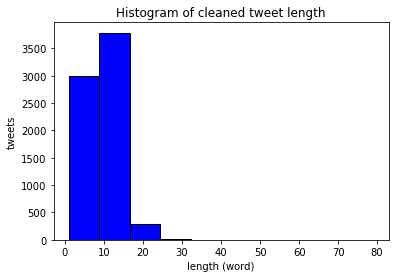

In [16]:
print(TRAIN_DATA["Text_len"].describe())

plt.hist(TRAIN_DATA["Text_len"], color='blue', edgecolor='black')
plt.title('Histogram of cleaned tweet length')
plt.xlabel('length (word)')
plt.ylabel('tweets')
plt.show()

In [17]:
for i, t in TRAIN_DATA.iterrows():
    if t["Text_len"] > 30:
        print("BEFORE:", t["Tweet"])
        print("AFTER :", t["Text"])
        print()

BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ #fuming
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charact frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector fume

BEFORE: Good morning, Trondheim! #optimism #productivity ⛅️❤️🇳🇴🏢💻🖥🏋🏻💪🏼📺🍿
AFTER : good morn trondheim optim product sun behind cloud red heart selector norway offic build laptop comput desktop comput person lift weight light skin tone flex bicep medium light skin tone televis popcorn

BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ 
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charact frown face selector frown fa

## Retrive pre-trained GloVe word embedding

In [18]:
# zip_file_url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
print('loading word embeddings from GloVe...')

embeddings_index = {}
f = codecs.open('../gloVe/glove.twitter.27B.200d.txt', encoding='utf-8')

for line in tqdm(f, total=1193515):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings from GloVe...


100%|██████████| 1193515/1193515 [01:26<00:00, 13820.35it/s]

found 1193514 word vectors


## tokenzing data

In [19]:
counter = collections.Counter(word for text in TRAIN_DATA['Text'] for word in text.split())
words_list = sorted(counter.items(), key=lambda x:x[1], reverse=True)
word_index = {word[0]: i+1 for i, word in enumerate(words_list)}
print("dictionary size: ", len(word_index))

dictionary size:  10000


In [21]:
#embedding matrix
print('preparing embedding matrix...')

words_not_found = []
nb_words = len(word_index) + 1
embed_dim = 200
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 2867
sample words not found:  ['overdos' 'pinafor' 'nojobsinbiolog' '3499' 'debates2016' 'lovinle'
 'endlessposs' 'willxb' 'ruthann' 'milleni']


In [22]:
def words_to_seq(words):
    return np.array([word_index.get(word, 0) for word in words])

def prep(data):
    X_data = []
    y_data = []
    
    for X, y in zip(data["Tweet"], data["Label"]):
        words = pre_process(X).split()
        if len(words) > 0:
            X_data.append(words_to_seq((words)))
            y_data.append(y)
            
    return X_data, y_data

In [23]:
X_train, y_train = prep(TRAIN_DATA)
X_dev, y_dev = prep(DEV_DATA)

In [24]:
label_distribution = collections.Counter(y_train)
class_weights = [label_distribution[i] / sum(label_distribution.values()) for i in range(4)]
class_weights

[0.23950999718389185,
 0.31709377640101377,
 0.22754153759504364,
 0.21585468882005068]

## LSTM model

In [25]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, hidden_dim, no_layers, dropout, train_emb):
        super(LSTM, self).__init__()
        self.no_layers = no_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = train_emb
        
        self.dimension = hidden_dim
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=self.dimension,
                            num_layers=self.no_layers,
                            batch_first=True)
        self.drop = nn.Dropout(p=dropout)

        self.fc = nn.Linear(self.hidden_dim, 4)

    def forward(self, text):

        text_len = np.array([len(t) for t in text]) 
        
        padded_input = pad_sequence(text, batch_first=True)
        embbed_input = self.embedding(padded_input)
        packed_input = pack_padded_sequence(embbed_input, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, output_len = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = torch.cat([torch.mean(t[:l], 0, keepdim=True) for (t, l) in zip(output, output_len)])
        text_fea = self.drop(out_forward)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out     

## bi-LSTM model

In [26]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class bi_LSTM(nn.Module):

    def __init__(self, hidden_dim, no_layers, dropout, train_emb):
        super(bi_LSTM, self).__init__()
        self.no_layers = no_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = train_emb
        
        self.dimension = hidden_dim
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=self.dimension,
                            num_layers=self.no_layers,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=dropout)

        self.fc = nn.Linear(2*self.hidden_dim, 4)

    def forward(self, text):

        text_len = np.array([len(t) for t in text]) 
        
        padded_input = pad_sequence(text, batch_first=True)
        embbed_input = self.embedding(padded_input)
        packed_input = pack_padded_sequence(embbed_input, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, output_len = pad_packed_sequence(packed_output, batch_first=True)

        
        out_forward = torch.cat([torch.mean(t[:l, :self.dimension], 0, keepdim=True) for (t, l) in zip(output, output_len)])
        out_reverse = torch.cat([torch.mean(t[-l:, self.dimension:], 0, keepdim=True) for (t, l) in zip(output, output_len)])             
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out      

## Main training function

In [27]:
def train(model, verbose=True):
    
    clip = 5
    epochs = 30
    batch_size = 100
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))

    valid_loss_min = np.Inf
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]

    for epoch in tqdm(range(epochs)):
        train_losses = []
        train_acc = 0.0
        model.train()

        for start in range(0, len(X_train), batch_size):

            inputs = [torch.from_numpy(t) for t in X_train[start: start+batch_size]]
            labels = torch.Tensor(y_train[start: start+batch_size]).long()

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_acc += acc(output, labels)

            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)

        with torch.no_grad():
            val_losses = []
            val_acc = 0.0
            model.eval()

            for start in range(0, len(X_dev), batch_size): 
                v_inputs = [torch.from_numpy(t) for t in X_dev[start: start+batch_size]]
                v_labels = torch.Tensor(y_dev[start: start+batch_size]).long()

                output = model(v_inputs)
                val_loss = criterion(output, v_labels)

                val_losses.append(val_loss.item())
                accuracy = acc(output, v_labels)
                val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(X_train)
        epoch_val_acc = val_acc/len(X_dev)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)


        if verbose:
            print(25*'==')
            print(f'Epoch {epoch+1}') 
            print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
            print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), PATH)
            if verbose:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
 
    if verbose:
        # plot acc, loss per epoche
        plot_acc_loss(epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss)

    # report dev acc
    report(model, verbose)


## Helper functions

In [28]:
# function to predict accuracy
def acc(pred, label):
    pred = torch.argmax(pred, 1)
    return torch.sum(pred == label).item()

In [29]:
# function to plot the accuracy and loss
def plot_acc_loss(tr_acc, vl_acc, tr_loss, vl_loss):
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(tr_acc, label='Train Acc')
    plt.plot(vl_acc, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(tr_loss, label='Train loss')
    plt.plot(vl_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()

    plt.show()

In [30]:
# function to report the accuracy on dev set
def report(model, verbose=True):
#     saved_model = LSTM(hidden_dim, no_layers, dropout, train_emb)

    saved_model = model
    saved_model.load_state_dict(torch.load(PATH))
    saved_model.eval()

    inputs = v_inputs = [torch.from_numpy(t) for t in X_dev]
    output = saved_model(inputs)
    y_pred = torch.argmax(output, 1).data.numpy()

    if verbose:
        print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
    print(accuracy_score(y_dev, y_pred))

In [31]:
PATH = 'LSTM_working/state_dict.pt'

In [32]:
# bi-LSTM
# hidden_dim = 256
# no_layers = 3
# dropout = 0.0
# train_emb = True

# model = bi_LSTM(hidden_dim, no_layers, dropout, train_emb)
# lr = 0.002
# w_decay = 5e-4
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=w_decay)

# print(25*'==')
# print(model)
# print(optimizer)
# train(model, verbose=False)
# print("parameters:", hidden_dim, no_layers, dropout, lr, w_decay)
# os.rename(PATH, BEST_BILSTM_PATH)
# print(25*'==')

## Analyze tweets with our best model

In [33]:
# Best model parameters
hidden_dim = 256
no_layers = 3
dropout = 0.0
train_emb = True
BEST_BILSTM_PATH = 'LSTM_working/best_biLSTM_state_dict.pt'

In [34]:
best_model = bi_LSTM(hidden_dim, no_layers, dropout, train_emb)
best_model.load_state_dict(torch.load(BEST_BILSTM_PATH))
best_model.eval()

bi_LSTM(
  (embedding): Embedding(10001, 200)
  (lstm): LSTM(200, 256, num_layers=3, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [36]:
inputs = [torch.from_numpy(t) for t in X_dev]
output = best_model(inputs)
y_pred = torch.argmax(output, 1).data.numpy()
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print("Accuracy=", accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.47      0.40      0.43       388
        fear       0.41      0.55      0.47       389
         joy       0.67      0.64      0.66       290
     sadness       0.44      0.36      0.40       396

    accuracy                           0.48      1463
   macro avg       0.50      0.49      0.49      1463
weighted avg       0.48      0.48      0.48      1463

Accuracy= 0.4784688995215311


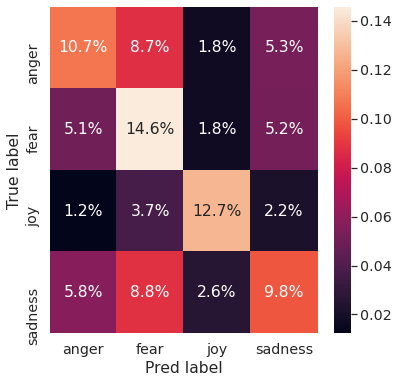

In [51]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(6,6))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.1%', annot=True, xticklabels=EMOTIONS, yticklabels=EMOTIONS)
ax.set(xlabel='Pred label', ylabel='True label')
sns.set(font_scale=1.3)
plt.show()

## Apply Best Model On Real World Tweets

In [46]:
SAMPLED_DIR = "../sampled_data/clean_2000/"
FILE_SUFFIX = "_sampled_clean.csv"
FILES = [str(i).zfill(2) + FILE_SUFFIX for i in range(1, 13)]

In [47]:
df = pd.DataFrame()
for file in FILES:
    df_month = pd.read_csv(SAMPLED_DIR + file, dtype=object)
    df = pd.concat([df, df_month])
df

,Unnamed: 0,id_str,full_text,date,created_at,lang
0,4327,1220108919969763328,RT @WHO: The Emergency Committee on the novel ...,2020-01-22,NaN,NaN
1,1600,1220020464204107776,RT @PhilippineStar: The Department of Health i...,2020-01-22,NaN,NaN
2,718,1220045946777505792,.@WHO presser on whether to declare a #PHEIC f...,2020-01-22,NaN,NaN
3,906,1220071591708712962,RT @WHO: LIVE: Press conference on the Emergen...,2020-01-22,NaN,NaN
4,2897,1220066709647908876,RT @HuXijin_GT: Shutting down outbound transpo...,2020-01-22,NaN,NaN
...,...,...,...,...,...,...
7995,0,1334706183316320256,RT @DavidKorins: It took 248 days to reach 7 m...,2020-12-04,Fri Dec 04 03:48:46 +0000 2020,en
7996,0,1334862159143120898,@PublicHealthW That Christmas Covid ignorance ...,2020-12-04,Fri Dec 04 14:08:33 +0000 2020,en
7997,0,1334895153295872001,"This will take time to implement, Acierno and ...",2020-12-04,Fri Dec 04 16:19:40 +0000 2020,en
7998,0,1334947064539729920,RT @NicoleKuderer: Quote of the Day 🌟Gov. Jay ...,2020-12-04,Fri Dec 04 19:45:56 +0000 2020,en


In [48]:
df["date"].value_counts().sort_index()

2020-01-22    2000
2020-01-23    2000
2020-01-24    2000
2020-01-25    2000
2020-01-26    2000
              ... 
2020-11-30    2000
2020-12-01    2000
2020-12-02    2000
2020-12-03    2000
2020-12-04    2000
Name: date, Length: 317, dtype: int64

In [49]:
day_tweet = collections.defaultdict(list)
day_sentiments = collections.defaultdict(list)

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        sentence = pre_process(row["full_text"])
        words = sentence.split()
        if len(words) > 0:
            day_tweet[row["date"]].append(words_to_seq(words))
            day_sentiments[row["date"]].append(TextBlob(sentence).sentiment.polarity)
    except:
        pass

634005it [18:42, 564.63it/s]


## Dates

In [53]:
dates = sorted([x for x in df["date"].unique() if str(x) != 'nan'])

In [55]:
# Sentiment
daily_sentiment = {}
print("sentiment")
for d in dates:
    mean_sentiment = sum(day_sentiments[d]) / len(day_sentiments[d])
    daily_sentiment[d] = mean_sentiment

sentiment


In [56]:
# Emotion
daily_emo = dict()
print("emotion")
for date, tokenized_tweets in tqdm(day_tweet.items()):
    inputs = [torch.from_numpy(t) for t in tokenized_tweets]
    output = best_model(inputs)
    y_pred = torch.argmax(output, 1).data.numpy()
    
    emo_count = [0, 0, 0, 0]
    for y in y_pred:
        emo_count[y] += 1
    
    daily_emo[date] = emo_count

  0%|          | 0/318 [00:00<?, ?it/s]

emotion


100%|██████████| 318/318 [12:05<00:00,  2.28s/it]


In [82]:
# Tweet collected by dataset 
daily_tweeter_counts = collections.defaultdict(list)
print("Tweet counts")
with open("../data_prepare/daily_tweet_count.txt") as reader:
    for line in reader:
        l = line.strip("\n").split()
        daily_tweeter_counts[l[0]] = int(l[1])

## New confirmed cases data

In [57]:
GLOBAL_DATA_LOC = "./owid-covid-data.csv"
cases_df = pd.read_csv(GLOBAL_DATA_LOC)

In [58]:
cases_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-01-23,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-24,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-25,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-26,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-27,NaN,0.0,NaN,NaN,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [59]:
z_df = cases_df.fillna(0)

In [60]:
date_newcase = collections.defaultdict(int)
date_accu = collections.defaultdict(int)
for i, row in z_df.iterrows():   
    d = row["date"]
    date_newcase[d] += int(row["new_cases"])
    date_accu[d] += int(row["total_cases"])

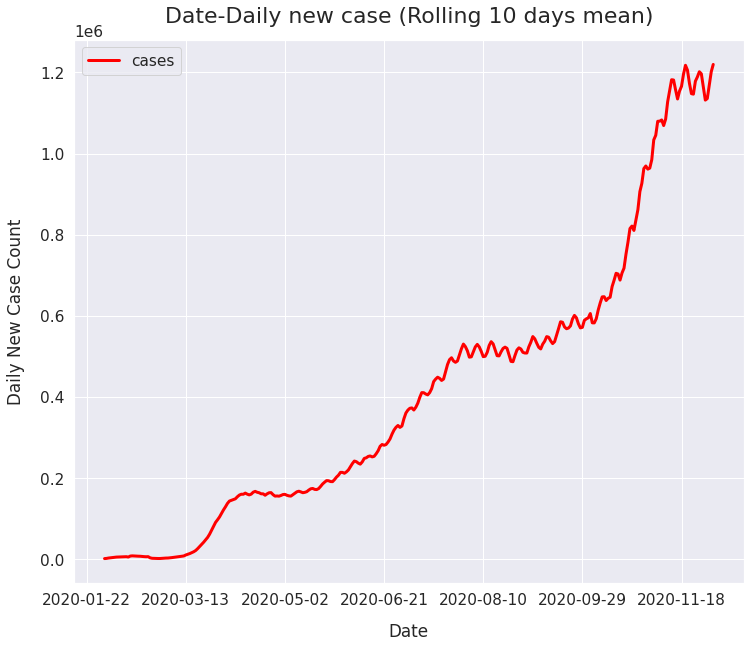

In [67]:
df_new_cases = pd.DataFrame({'date': dates, 'cases': [date_newcase[d] for d in dates]})

df_new_cases.rolling(10, on='date').mean().plot(x="date", figsize=(12, 10), linewidth=3, color='red')
plt.xlabel("Date", labelpad=15)
plt.ylabel("Daily New Case Count", labelpad=15)
plt.title("Date-Daily new case (Rolling 10 days mean)", y=1.02, fontsize=22);
plt.show()
plt.show()

## Tweets collected

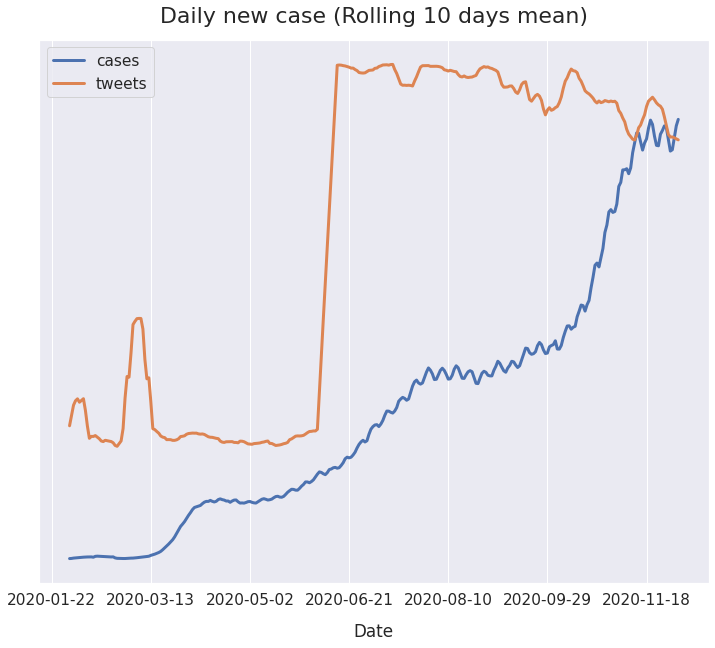

In [94]:
df_tweet_count = pd.DataFrame({'date': dates, 
                               'cases': [date_newcase[d] for d in dates],
                               'tweets': [daily_tweeter_counts[d] for d in dates],
                              })

m = df_tweet_count["cases"].max()
df_tweet_count["cases"] = df_tweet_count["cases"].apply(lambda x: x / m)

m = df_tweet_count["tweets"].max()
df_tweet_count["tweets"] = df_tweet_count["tweets"].apply(lambda x: x / m)

df_tweet_count.rolling(10, on='date').mean().plot(x="date", figsize=(12, 10), linewidth=3)
plt.xlabel("Date", labelpad=15)
# plt.ylabel("Daily New Case Count", labelpad=15)
plt.title("Daily new case (Rolling 10 days mean)", y=1.02, fontsize=22);
plt.yticks([])
plt.show()

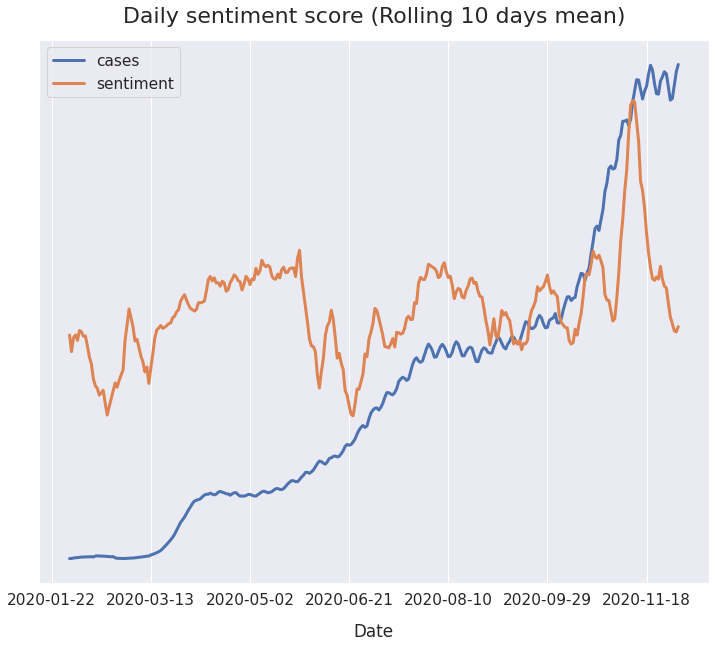

In [106]:
df_tweet_sentiment = pd.DataFrame({'date': dates, 
                                   'cases': [date_newcase[d] for d in dates],
                                   'sentiment': [daily_sentiment[d] for d in dates]
                                  })

m = df_tweet_sentiment["cases"].max()
df_tweet_sentiment["cases"] = df_tweet_sentiment["cases"].apply(lambda x: x / m)

m = df_tweet_sentiment["sentiment"].max()
df_tweet_sentiment["sentiment"] = df_tweet_sentiment["sentiment"].apply(lambda x: x / m)

df_tweet_sentiment.rolling(10, on='date').mean().plot(x="date", figsize=(12, 10), linewidth=3)
plt.xlabel("Date", labelpad=15)
# plt.ylabel("Daily New Case Count", labelpad=15)
plt.title("Daily sentiment score (Rolling 10 days mean)", y=1.02, fontsize=22);
plt.yticks([])
plt.show()

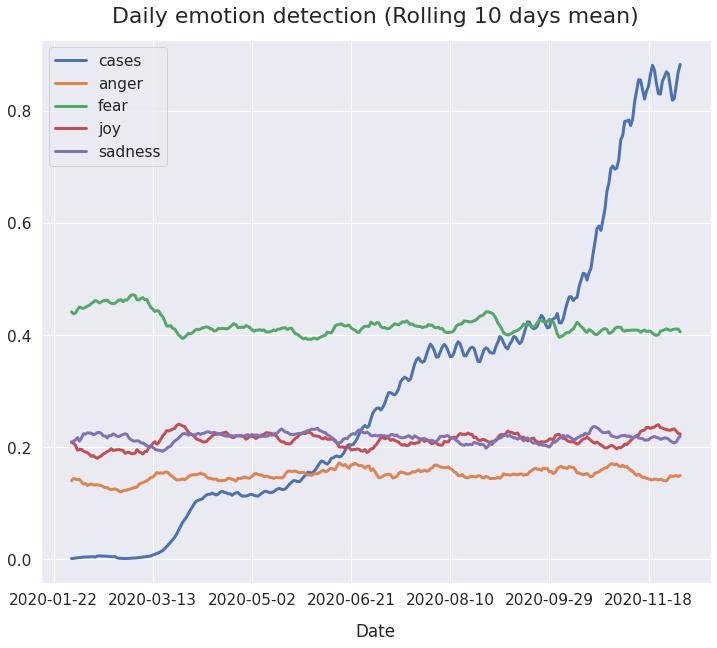

In [115]:
df_tweet_emotion = pd.DataFrame({'date': dates, 
                                 'cases': [date_newcase[d] for d in dates],
                                 EMOTIONS[0]: [daily_emo[d][0] for d in dates],
                                 EMOTIONS[1]: [daily_emo[d][1] for d in dates],
                                 EMOTIONS[2]: [daily_emo[d][2] for d in dates],
                                 EMOTIONS[3]: [daily_emo[d][3] for d in dates]
                                 })

m = df_tweet_emotion["cases"].max()
df_tweet_emotion["cases"] = df_tweet_emotion["cases"].apply(lambda x: x / m)

m = 0
for e in EMOTIONS:
    m = max(m, df_tweet_emotion[e].max())                         
for e in EMOTIONS:
    df_tweet_emotion[e] = df_tweet_emotion[e].apply(lambda x: x / 2000)

df_tweet_emotion.rolling(10, on='date').mean().plot(x="date", figsize=(12, 10), linewidth=3)
plt.xlabel("Date", labelpad=15)
plt.title("Daily emotion detection (Rolling 10 days mean)", y=1.02, fontsize=22);
plt.show()

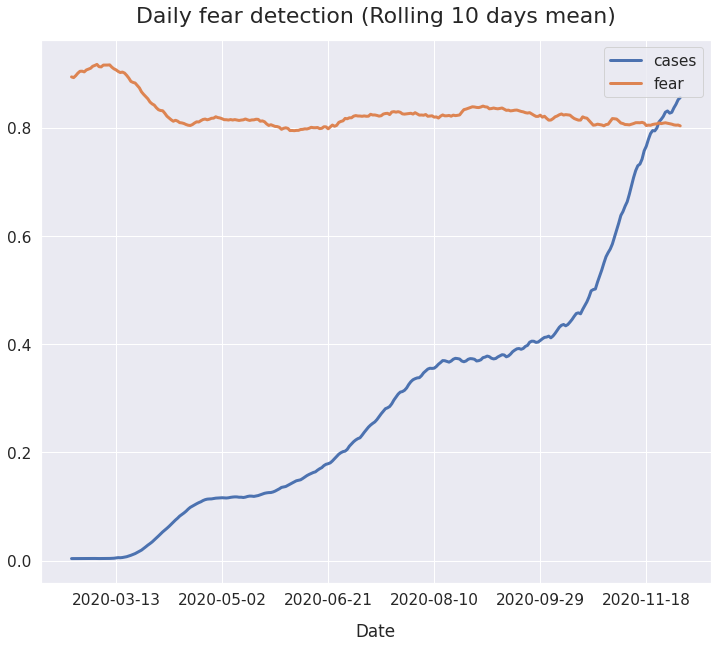

In [118]:
df_tweet_emotion = pd.DataFrame({'date': dates, 
                                 'cases': [date_newcase[d] for d in dates],
                                 'fear': [daily_emo[d][1] for d in dates]})

m = df_tweet_emotion["cases"].max()
df_tweet_emotion["cases"] = df_tweet_emotion["cases"].apply(lambda x: x / m)

m = df_tweet_emotion["fear"].max()                         
df_tweet_emotion["fear"] = df_tweet_emotion["fear"].apply(lambda x: x / m)

df_tweet_emotion.rolling(30, on='date').mean().plot(x="date", figsize=(12, 10), linewidth=3)
plt.xlabel("Date", labelpad=15)
plt.title("Daily fear detection (Rolling 10 days mean)", y=1.02, fontsize=22);
plt.show()